# NCAA Basic Data Analysis

Lenny Fan

Mar 17, 2018

In [1]:
import numpy as np
import pandas as pd

***

# Get Data

In [203]:
# main compact
seasonsData = pd.read_csv("RegularSeasonDetailedResults.csv")
tournamentsData = pd.read_csv("NCAATourneyDetailedResults.csv")
teams = pd.read_csv("Teams.csv")
# some other compact
SecondaryTourneyCompactResults = pd.read_csv("SecondaryTourneyCompactResults.csv")
ConferenceTourneyGames = pd.read_csv("ConferenceTourneyGames.csv")
NCAATourneyCompactResults = pd.read_csv("NCAATourneyCompactResults.csv")
RegularSeasonCompactResults = pd.read_csv("RegularSeasonCompactResults.csv")

# rank
MasseyOrdinals = pd.read_csv("MasseyOrdinals.csv")

# seed
NCAATourneySeeds = pd.read_csv("NCAATourneySeeds.csv")
# ignore area
def seedclean(var):
    if var[1] != "0":
        if var[-1].isdigit():
            return int(var[1:])
        else:
            return int(var[1:-1])
    else:
        if var[-1].isdigit():
            return int(var[2:])
        else:
            return int(var[2:-1])
NCAATourneySeeds.Seed = NCAATourneySeeds.Seed.apply(seedclean)

***
# Data Extraction

## Combine the Detailed Results

- Detailed Combine

> tournamentsData

> seasonsData

In [5]:
def location_to_1(var):
    if var == "N":
        return 0
    if var == "A":
        return -1
    if var == "H":
        return 1
    else:
        return 0
def delete_w(var):
    if var[0] == "W":
        return var[1:]
    return var
def delete_l(var):
    if var[0] == "L":
        return var[1:]
    return var    

In [6]:
# set tournamy
tournamentsData["tournamy"] = 1

# ConferenceTourneyGames
# set to be 0.7 else 0
seasonsData["S_D_W_L"] = map(tuple,seasonsData[["Season","DayNum","WTeamID","LTeamID"]].as_matrix())
ConferenceTourneyGamesset = set(map(tuple,
                                    ConferenceTourneyGames[ConferenceTourneyGames.Season>= 2003][
                                                     ["Season","DayNum","WTeamID","LTeamID"]].as_matrix()))
seasonsData["tournamy"] = seasonsData["S_D_W_L"].apply(lambda var: 0.7 if var in ConferenceTourneyGamesset 
                                                                       else 0)
seasonsData.drop("S_D_W_L",axis = 1,inplace = True)

# combine
df = pd.concat([tournamentsData,seasonsData],ignore_index=True)

      **fill up null value for free-throw precentage by min(mean(team average),total FTP**

In [7]:
teamaverage = 1.0*df.groupby("WTeamID")["WFTM"].sum()/df.groupby("WTeamID")["WFTA"].sum()
allaverage = 1.0*df.WFTM.sum() / df.WFTA.sum()
def filluptreethrow(cols):
    teamid, FTM, FTA = cols[0],cols[1],cols[2]
    
    if FTA != 0:
        return 1.0*FTM/FTA
    else:
        return min(allaverage,teamaverage[teamid])

df["WFTP"] = df[['WTeamID','WFTM','WFTA']].apply(filluptreethrow,axis = 1)
df["LFTP"] = df[['LTeamID','LFTM','LFTA']].apply(filluptreethrow,axis = 1)
df["WFGP"] = df.WFGM*1.0/df.WFGA
df["LFGP"] = df.LFGM*1.0/df.LFGA
df["WFGP3"] = df.WFGM3*1.0/df.WFGA
df["LFGP3"] = df.LFGM3*1.0/df.LFGA
df["loc"] = df.WLoc.apply(lambda var: location_to_1(var))
df["NScore"] = df.WScore - df.LScore
df["NFGP"] = df.WFGP - df.LFGP
df["NFGP3"] = df.WFGP3 - df.LFGP3
df["NFTP"] = df.WFTP - df.LFTP ##
df["NOR"] = df.WOR - df.LOR
df["NDR"] = df.WDR - df.LDR
df["NAst"] = df.WAst - df.LAst
df["NTO"] = df.WTO - df.LTO
df["NStl"] = df.WStl - df.LStl
df["NBlk"] = df.WBlk - df.LBlk
df["NPF"] = df.WPF - df.LPF 
df["win"] = 1


winteam_df = df[[
     u'Season', u'DayNum', u'WTeamID', u'LTeamID', 
     u'tournamy', u'loc', u'NumOT', 'win',
     u'WScore', u'WOR', u'WDR', u'WAst', u'WTO', u'WStl', u'WBlk', u'WPF', u'WFGP', u'WFGP3', u'WFTP', 
     u'NScore', u'NFGP', u'NFGP3', u'NFTP', u'NOR', u'NDR', u'NAst', u'NTO', u'NStl',u'NBlk', u'NPF',
     u'WFGM', u'WFGA', u'WFGM3', u'WFGA3', u'WFTM',u'WFTA' ]]
winteam_df= winteam_df.rename({'WTeamID': 'aTeamID', 'LTeamID': 'bTeamID'}, axis='columns')

linteam_df = pd.concat([df[[
     u'Season', u'DayNum', u'LTeamID', u'WTeamID', 
     u'tournamy', u'loc', u'NumOT', 'win',
     u'LScore', u'LOR', u'LDR', u'LAst', u'LTO', u'LStl', u'LBlk', u'LPF', u'LFGP', u'LFGP3', u'LFTP']],
     -1*df[[u'NScore', u'NFGP', u'NFGP3', u'NFTP', u'NOR', u'NDR', u'NAst', u'NTO', u'NStl',u'NBlk', u'NPF']],
     df[[u'LFGM', u'LFGA', u'LFGM3', u'LFGA3', u'LFTM',u'LFTA' ]]],axis =1)
linteam_df.win = 0
linteam_df["loc"] = linteam_df["loc"]*-1
linteam_df = linteam_df.rename({'WTeamID': 'bTeamID', 'LTeamID': 'aTeamID'}, axis='columns')

winteam_df.columns= map(delete_w,winteam_df.columns)
linteam_df.columns= map(delete_l,linteam_df.columns)

finalsearch = pd.concat([winteam_df,linteam_df],ignore_index=True)

## Combine other results

> SecondaryTourneyCompactResults

> ConferenceTourneyGames : this is NOT a new listing of games;

> NCAATourneyCompactResults

> RegularSeasonCompactResults 

In [74]:
SecondaryTourneyCompactResults[:1]

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,SecondaryTourney
0,1985,136,1151,67,1155,65,H,0,NIT


In [75]:
# we have detail after 2003
RegularSeasonCompactResults = RegularSeasonCompactResults[RegularSeasonCompactResults.Season < 2003 ]
RegularSeasonCompactResults[:1]

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0


In [76]:
NCAATourneyCompactResults = NCAATourneyCompactResults[NCAATourneyCompactResults.Season < 2003]
NCAATourneyCompactResults[:1]

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0


In [77]:
# let secondary tourney = 0.4
SecondaryTourneyCompactResults["tournamy"] = 0.4
SecondaryTourneyCompactResults.drop("SecondaryTourney",axis = 1,inplace=True)
NCAATourneyCompactResults["tournamy"] = 1
# ConferenceTourneyGames
# set to be 0.7 else 0
RegularSeasonCompactResults["S_D_W_L"] = map(tuple,RegularSeasonCompactResults[
                                        ["Season","DayNum","WTeamID","LTeamID"]].as_matrix())
ConferenceTourneyGamesset = set(map(tuple,
                                    ConferenceTourneyGames[ConferenceTourneyGames.Season< 2003][
                                                     ["Season","DayNum","WTeamID","LTeamID"]].as_matrix()))
RegularSeasonCompactResults["tournamy"] = RegularSeasonCompactResults["S_D_W_L"].apply(
    lambda var: 0.7 if var in ConferenceTourneyGamesset else 0)
RegularSeasonCompactResults.drop("S_D_W_L",axis = 1,inplace = True)

df2 = pd.concat([SecondaryTourneyCompactResults,
                NCAATourneyCompactResults,
                RegularSeasonCompactResults],ignore_index=True)


df2["loc"] = df2.WLoc.apply(lambda var: location_to_1(var))
df2["NScore"] = df2.WScore - df2.LScore
df2["win"] = 1
df2["FGP"] = 0
df2["FGP3"] = 0
df2["FTP"] = 0
df2["NFGP"] = 0
df2["NFGP3"] = 0
df2["NFTP"] = 0
df2["NOR"] = 0
df2["NDR"] = 0
df2["NAst"] = 0
df2["NTO"] = 0
df2["NStl"] = 0
df2["NBlk"] = 0
df2["NPF"] = 0
df2['OR'] = 0
df2['DR'] = 0
df2['Ast'] = 0
df2['TO'] = 0 
df2['Stl'] = 0
df2['Blk'] = 0
df2['FGM'] = 0
df2['FGA'] = 0
df2['FGM3'] = 0
df2['FGA3'] = 0
df2['FTM'] = 0
df2['FTA'] = 0
df2['PF'] = 0

winteam_df = df2[[
     u'Season', u'DayNum', u'WTeamID', u'LTeamID', 
     u'tournamy', u'loc', u'NumOT', 'win',
     u'WScore', u'OR', u'DR', u'Ast', u'TO', u'Stl', u'Blk', u'PF', u'FGP', u'FGP3', u'FTP', 
     u'NScore', u'NFGP', u'NFGP3', u'NFTP', u'NOR', u'NDR', u'NAst', u'NTO', u'NStl',u'NBlk', u'NPF',
     u'FGM', u'FGA', u'FGM3', u'FGA3', u'FTM',u'FTA' ]]
winteam_df= winteam_df.rename({'WTeamID': 'aTeamID', 'LTeamID': 'bTeamID','WScore':'Score'}, axis='columns')

linteam_df = pd.concat([df2[[
     u'Season', u'DayNum', u'LTeamID', u'WTeamID', 
     u'tournamy', u'loc', u'NumOT', 'win',
     u'LScore', u'OR', u'DR', u'Ast', u'TO', u'Stl', u'Blk', u'PF', u'FGP', u'FGP3', u'FTP']],
     -1*df2[[u'NScore', u'NFGP', u'NFGP3', u'NFTP', u'NOR', u'NDR', u'NAst', u'NTO', u'NStl',u'NBlk', u'NPF']],
     df2[[u'FGM', u'FGA', u'FGM3', u'FGA3', u'FTM',u'FTA' ]]],axis =1)
linteam_df.win = 0
linteam_df["loc"] = linteam_df["loc"]*-1
linteam_df = linteam_df.rename({'WTeamID': 'bTeamID', 'LTeamID': 'aTeamID','LScore':'Score'}, axis='columns')

second_finalsearch = pd.concat([winteam_df,linteam_df],ignore_index=True)
second_finalsearch.shape

In [81]:
# create a searching table to find the teams stats
wholesearch = pd.concat([second_finalsearch,finalsearch],ignore_index=True)

## Get the individual team recent states 

- last_k_game

- last_season

- this_season

- recent rank

- season seed

In [86]:
def last_k_game(day,sea,Id,k=10):
    """ 
    return 1d array = (36-3)*k
    (drop the Season,teamID features)
    
    return 'DayNum', u'tournamy', u'loc',
       u'NumOT', u'win', u'Score', u'OR', u'DR', u'Ast', u'TO', u'Stl', u'Blk',
       u'PF', u'FGP', u'FGP3', u'FTP', u'NScore', u'NFGP', u'NFGP3', u'NFTP',
       u'NOR', u'NDR', u'NAst', u'NTO', u'NStl', u'NBlk', u'NPF', u'FGM',
       u'FGA', u'FGM3', u'FGA3', u'FTM', u'FTA'
    """
    last_k_df = wholesearch[(wholesearch.aTeamID == Id) & (wholesearch.Season <= sea) & 
            ((wholesearch.DayNum < day) | (wholesearch.Season < sea))].sort_values(
                by = ["Season","DayNum"],ascending=False)[:k]
    
    #return last_k_df
    rtn = []
    count = k
    for _,row in last_k_df.iterrows():
        row = row.copy()
        # if the day is more close to game, impact more
        # 1/day differece
        if row.Season == sea:
            row.DayNum = 1.0/(day - row.DayNum)
        else:
            row.DayNum = 1.0/(365*(sea - row.Season))
        # drop the season (not usefule)
        rtn += list(row.drop(["Season","aTeamID","bTeamID"]))
        count -= 1
    
    return rtn + list(np.zeros(33*count))
len(last_k_game(132,2017,1181))

330

In [87]:
def last_season(sea,Id):
    """ 
    return 1d array = (36-3)
    (drop the Season and team)
    """
    
    last_s_df = wholesearch[(wholesearch.aTeamID == Id) & (wholesearch.Season == sea-1)].copy()
    last_s_df = last_s_df[last_s_df.FGA != 0]
    last_s_df.DayNum = 1.0/365
    last_s_df.loc = 0
    
    if last_s_df.shape[0]:
        return np.array(last_s_df.mean().drop(["Season","bTeamID","aTeamID"]))
    return np.zeros(33)

len(last_season(2017,1181))

33

In [88]:
def this_season(day,sea,Id):
    """
    return the average of the season before given day
           1d array = (36-3)
           (drop the Season and team)
    """
    this_s_df = wholesearch[(wholesearch.aTeamID == Id) & (wholesearch.Season == sea) & 
                            (wholesearch.DayNum < day)].copy()
    this_s_df = this_s_df[this_s_df.FGA != 0]
    #this_s_df.DayNum = 1.0
    this_s_df.loc = 0
    
    if this_s_df.shape[0]:
        return np.array(this_s_df.mean().drop(["Season","aTeamID","bTeamID"]))
    return np.zeros(33)

len(this_season(132,2017,1181))

33

In [89]:
def season_seed(sea,Id):
    """
    return 1/seed
    else 0
    """
    seed = NCAATourneySeeds[(NCAATourneySeeds.TeamID == Id) & (NCAATourneySeeds.Season == sea)].Seed

    if len(seed)==0:
        return 0
    return 1.0/seed.iloc[0]

print season_seed(2017,1181)
print season_seed(2017,1136)

In [91]:
def recent_rank(day,sea,Ida,Idb,spen = 10):
    """
    return +num if rank a >= rank b
           -num if rank a < rank b
           0 if a or b unrank
    """
    recentRankA = MasseyOrdinals[(MasseyOrdinals.Season == sea)&
                                 (MasseyOrdinals.RankingDayNum <= day)&
                                 (MasseyOrdinals.RankingDayNum > day-spen)&
                                 (MasseyOrdinals.TeamID == Ida)]
    
    recentRankB = MasseyOrdinals[(MasseyOrdinals.Season == sea)&
                                 (MasseyOrdinals.RankingDayNum <= day)&
                                 (MasseyOrdinals.RankingDayNum > day-20)&
                                 (MasseyOrdinals.TeamID == Idb)]
    
    if recentRankA.shape[0] == 0 or recentRankB.shape[0] == 0:
        # cant compare
        return 0
    return recentRankB.OrdinalRank.mean() - recentRankA.OrdinalRank.mean()
recent_rank(132,2017,1181,1136)

## get all history match 

In [107]:
# get all the match up
allgames = pd.read_csv("SecondaryTourneyCompactResults.csv")
allgamet = pd.read_csv("NCAATourneyCompactResults.csv")
allgamer = pd.read_csv("RegularSeasonCompactResults.csv")

allgames["tournamy"] = 0.4
allgames.drop("SecondaryTourney",axis = 1,inplace=True)
allgamet["tournamy"] = 1

# ConferenceTourneyGames
# set to be 0.7 else 0
allgamer["S_D_W_L"] = map(tuple,allgamer[["Season","DayNum","WTeamID","LTeamID"]].as_matrix())
ConferenceTourneyGamesset = set(map(tuple,
                                    ConferenceTourneyGames[["Season","DayNum","WTeamID","LTeamID"]].as_matrix()))
allgamer["tournamy"] = allgamer["S_D_W_L"].apply(lambda var: 0.7 if var in ConferenceTourneyGamesset 
                                                                       else 0)
allgamer.drop("S_D_W_L",axis = 1,inplace = True)

history_match = pd.concat([allgames,allgamer,allgamet],ignore_index=True)
history_match.drop(["WScore","LScore"],axis = 1, inplace=True)
history_match.WLoc = history_match.WLoc.apply(location_to_1)

whistory_match = history_match.copy()
whistory_match["win"] = 1
whistory_match["aID"] = whistory_match.WTeamID
whistory_match["bID"] = whistory_match.LTeamID
whistory_match["Loc"] = whistory_match.WLoc
whistory_match.drop(["WTeamID","LTeamID","WLoc","NumOT"],axis = 1,inplace = True)

lhistory_match = history_match.copy()
lhistory_match["win"] = 0
lhistory_match["aID"] = lhistory_match.LTeamID
lhistory_match["bID"] = lhistory_match.WTeamID
lhistory_match["Loc"] = -1*lhistory_match.WLoc
lhistory_match.drop(["WTeamID","LTeamID","WLoc","NumOT"],axis = 1,inplace = True)

totalhistory_match = pd.concat([whistory_match,lhistory_match],ignore_index=True)
print totalhistory_match.shape
totalhistory_match.head()

(308570, 7)


,Season,DayNum,tournamy,win,aID,bID,Loc
0,1985,136,0.4,1,1151,1155,1
1,1985,136,0.4,1,1153,1245,1
2,1985,136,0.4,1,1201,1365,1
3,1985,136,0.4,1,1231,1139,1
4,1985,136,0.4,1,1249,1222,1


## Get the Train

In [109]:
train = totalhistory_match.copy()

In [110]:
train["DSa"] = map(tuple,train[["DayNum","Season","aID"]].as_matrix())
a_last_k = pd.DataFrame(np.array(list(train.DSa.apply(
    lambda var: last_k_game(var[0],var[1],var[2])))),columns=range(1000,1330))

In [111]:
train["DSb"] = map(tuple,train[["DayNum","Season","bID"]].as_matrix())
b_last_k = pd.DataFrame(np.array(list(train.DSb.apply(
    lambda var: last_k_game(var[0],var[1],var[2])))),columns=range(2000,2330))

In [112]:
a_this_s = pd.DataFrame(np.array(list(train.DSa.apply(
    lambda var: this_season(var[0],var[1],var[2])))),columns=range(3000,3033))

In [113]:
b_this_s = pd.DataFrame(np.array(list(train.DSb.apply(
    lambda var: this_season(var[0],var[1],var[2])))),columns=range(4000,4033))

In [114]:
a_last_s = pd.DataFrame(np.array(list(train.DSa.apply(
    lambda var: last_season(var[1],var[2])))),columns=range(5000,5033))

In [115]:
b_last_s = pd.DataFrame(np.array(list(train.DSb.apply(
    lambda var: last_season(var[1],var[2])))),columns=range(6000,6033))

In [116]:
a_seed = pd.DataFrame(np.array(list(train.DSa.apply(
    lambda var: season_seed(var[1],var[2])))),columns=[7000])

In [117]:
b_seed = pd.DataFrame(np.array(list(train.DSb.apply(
    lambda var: season_seed(var[1],var[2])))),columns=[8000])

In [118]:
#train["DSab"] = map(tuple,train[["DayNum","Season","aID","bID"]].as_matrix())

#recent_rank(day,sea,Ida,Idb,spen = 20)
#train.loc[:,3000] = train.DSab.apply(lambda var: season_seed(var[0],var[1],var[2],var[3]))
#rank_d = pd.DataFrame(np.array(list(train.DSab.apply(
#    lambda var: recent_rank(var[0],var[1],var[2],var[3])))),columns=[3000])

In [119]:
train.drop(["DSa","DSb"],axis = 1,inplace = True)
#train.drop(["DSab"],axis = 1,inplace=True)
train = pd.concat([train,a_last_k,a_this_s,a_last_s,a_seed,
                         b_last_k,b_this_s,b_last_s,b_seed],axis =1)
train.head()

,Season,DayNum,tournamy,win,aID,bID,Loc,1000,1001,1002,...,6024,6025,6026,6027,6028,6029,6030,6031,6032,8000
0,1985,136,0.4,1,1151,1155,1,0.083333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1985,136,0.4,1,1153,1245,1,0.166667,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1985,136,0.4,1,1201,1365,1,0.125000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1985,136,0.4,1,1231,1139,1,0.250000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1985,136,0.4,1,1249,1222,1,0.142857,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [123]:
train.to_csv('final_train2')


---

# Final Data 

Basically, I get the last 10 games stats, season's average stats(before the game), last season's average stats and the seed (if exist) for Wteam and Lteam as the features.
       


       TeamID_df (One-Hot Encoding)
       |____ columns range(0,364)
       |________ teamA = 1
       |________ teamB = -1
       
       TeamA
       ********************************
       A_last_k_game
       |____ columns range(1000,1330)
       |________ 'DayNum':  1.0/(day - row.DayNum)
       |________ 'tournamy': 0, 0.4, 0.7, 1
       |________ 'loc': 1, 0, -1
       |________ 'NumOT': int
       |________ 'win': 1,0
       |________ 'Score': int
       |-----------------
       |________ 'OR': int
       |________ 'DR': int
       |________ 'Ast': int
       |________ 'TO': int
       |________ 'Stl': int
       |________ 'Blk': int
       |________ 'PF': %
       |________ 'FGP': %
       |________ 'FGP3': %
       |________ 'FTP': %  (has null value)
       |-----------------
       |________ 'NScore': int
       |________ 'NFGP': %
       |________ 'NFGP3': %
       |________ 'NFTP': % (has null value)
       |________ 'NOR': int
       |________ 'NDR': int
       |________ 'NAst': int
       |________ 'NTO': int
       |________ 'NStl': int
       |________ 'NBlk': int
       |________ 'NPF': int
       |-----------------
       |________ 'FGM': int
       |________ 'FGA': int
       |________ 'FGM3': int
       |________ 'FGA3': int
       |________ 'FTM': int
       |________ 'FTA': int
       |______________________(33*10)    
       ********************************
       A_this_season
       |____ columns range(3000,3033)
       |________ 'DayNum':  ?
       |________ 'tournamy': ??
       |________ 'loc': ??
       |________ 'NumOT': ??
       |________ 'win': 1,0 
       |________ 'Score': float
       |________ 'OR': float
       |________ 'DR': float
       |________ 'Ast': float
       |________ 'TO': float
       |________ 'Stl': float
       |________ 'Blk': float
       |________ 'PF': %
       |________ 'FGP': %
       |________ 'FGP3': %
       |________ 'FTP': %  (has null value)
       |-----------------
       |________ 'NScore': float
       |________ 'NFGP': %
       |________ 'NFGP3': %
       |________ 'NFTP': % (has null value)
       |________ 'NOR': float
       |________ 'NDR': float
       |________ 'NAst': float
       |________ 'NTO': float
       |________ 'NStl': float
       |________ 'NBlk': float
       |________ 'NPF': float
       |-----------------
       |________ 'FGM': float
       |________ 'FGA': float
       |________ 'FGM3': float
       |________ 'FGA3': float
       |________ 'FTM': float
       |________ 'FTA': float 
       ********************************
       A_last_season
       |____ columns range(5000,5033)
       |________ 'DayNum':  1.0/365 ??
       ********************************
       A_seed
       |____ columns [7000]
       |________ seed: 1.0/seedrank
       
       
       TeamB
       ********************************
       B_last_k_game
       |____ columns range(2000,2330)
       ********************************
       B_this_season
       |____ columns range(4000,4033)
       ********************************
       B_last_season
       |____ columns range(6000,6033)
       ********************************
       B_seed
       |____ columns [8000]
       |________ seed: 1.0/seedrank
       

In [8]:
train = pd.read_csv('final_train2',index_col=0)

In [9]:
train.head()

,Season,DayNum,tournamy,win,aID,bID,Loc,1000,1001,1002,...,6024,6025,6026,6027,6028,6029,6030,6031,6032,8000
0,1985,136,0.4,1,1151,1155,1,0.083333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1985,136,0.4,1,1153,1245,1,0.166667,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1985,136,0.4,1,1201,1365,1,0.125000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1985,136,0.4,1,1231,1139,1,0.250000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1985,136,0.4,1,1249,1222,1,0.142857,0.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## check null

In [11]:
(train.isnull().sum())[train.isnull().sum() != 0]

Series([], dtype: int64)

## Basic Analysis

### Is the team winning correlated to their last 10 game stats?

In [59]:
label33 = [u'DayNum', u'tournamy', u'loc',u'NumOT', 
           u'win', u'Score', u'OR', u'DR', u'Ast', u'TO', u'Stl', u'Blk', u'PF', 
           u'FGP', u'FGP3', u'FTP', 
           u'NScore', u'NFGP', u'NFGP3', u'NFTP',u'NOR', u'NDR', u'NAst', u'NTO', u'NStl', u'NBlk', u'NPF', 
           u'FGM',u'FGA', u'FGM3', u'FGA3', u'FTM', u'FTA']

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')

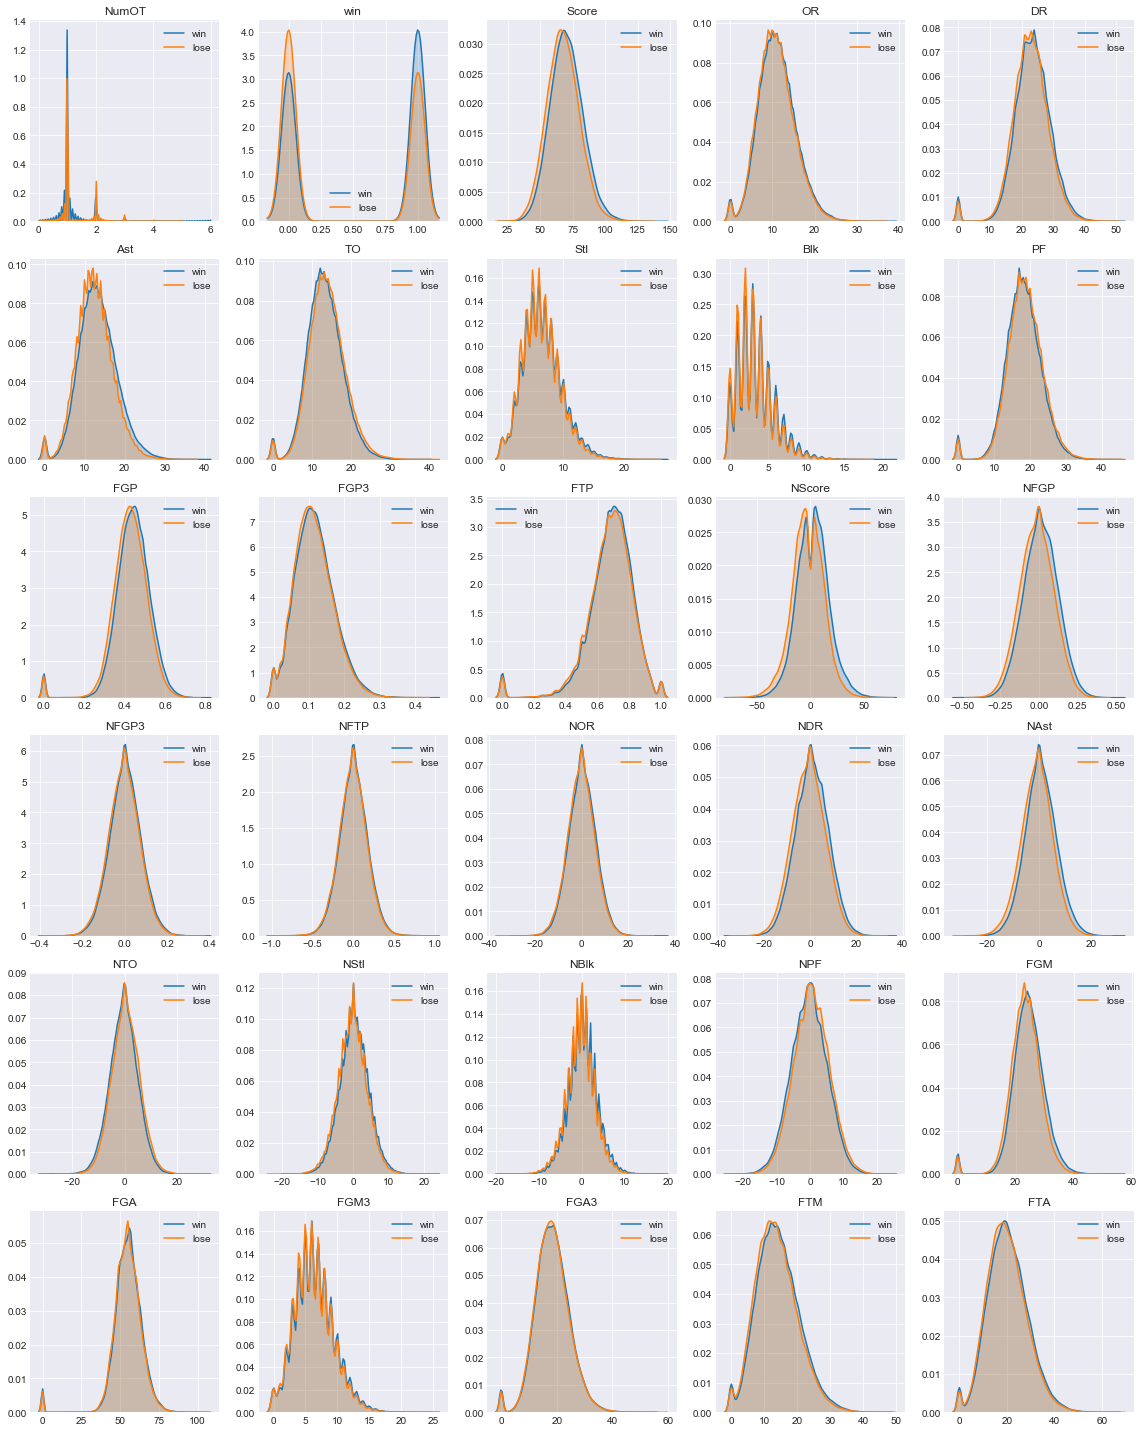

In [391]:
# plot the stats of the last game the team played
# only show the season after 2003
fig, axes = plt.subplots(nrows=6, ncols=5, figsize = (16,20))
for i in xrange(3,len(label33)):
    sns.kdeplot(train[(train["win"] == 1) & (train.Season >= 2003) & (train["1005"] != 0)][str(1000+i)],
                shade = True,label = "win",ax = axes[(i-3)/5][(i-3)%5])
    sns.kdeplot(train[(train["win"] == 0) & (train.Season >= 2003) & (train["1005"] != 0)][str(1000+i)],
                shade=True, label = "lose",ax = axes[(i-3)/5][(i-3)%5])
    axes[(i-3)/5][(i-3)%5].set_title(label33[i])
fig.tight_layout()

In [392]:
# The correlation of this game to last game
#plt.figure(figsize = (16,16))
#sns.heatmap(train[(train.Season >= 2003) & (train["1005"] != 0)]
#            [["win"]+map(str,range(1003,1033))].corr()
#            ,cmap='coolwarm',center = 0,xticklabels = ["TodayWin"] + label33[3:],yticklabels = ["TodayWin"] + label33[3:],
#            linecolor='w',linewidths = 0.5,cbar = False,vmax = 1,vmin =-1);

#### The Correlation table between team winning and last 10 games results

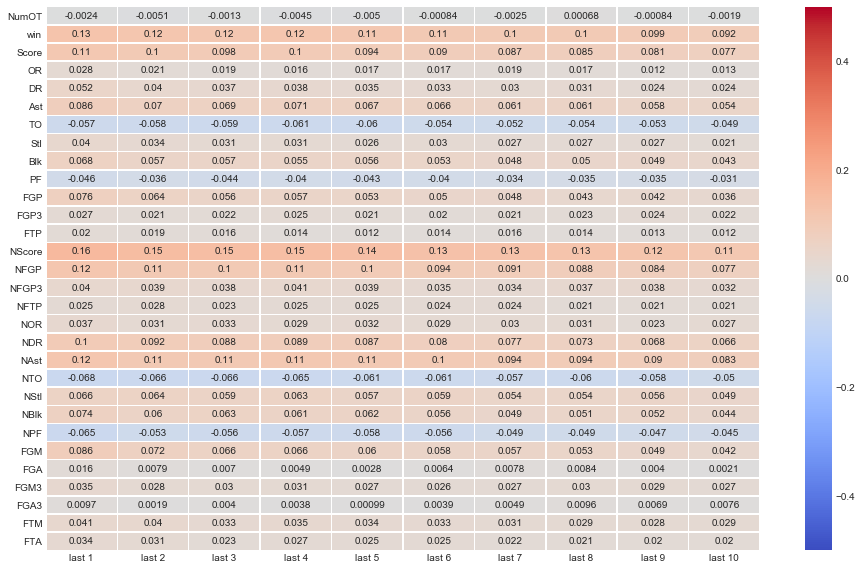

In [118]:
last10gameCorrTable = pd.DataFrame(index=label33[3:])
# check the correlation with the last 10 games
i = 0
while i < 10:
    last10gameCorrTable["last " + str(i+1)] = train[(train.Season >= 2003) & (train[str(1005+i*33)] != 0)][
                                                    ["win"]+map(str,range(1003+i*33,1033+i*33))
                                                    ].corr().iloc[0,1:].values
    i += 1
#last10gameCorrTable

plt.figure(figsize = (16,10))
sns.heatmap(last10gameCorrTable,cmap='coolwarm',center = 0,linecolor='w',linewidths = 0.5,vmax = 0.5,
            vmin = -0.5,annot = True);

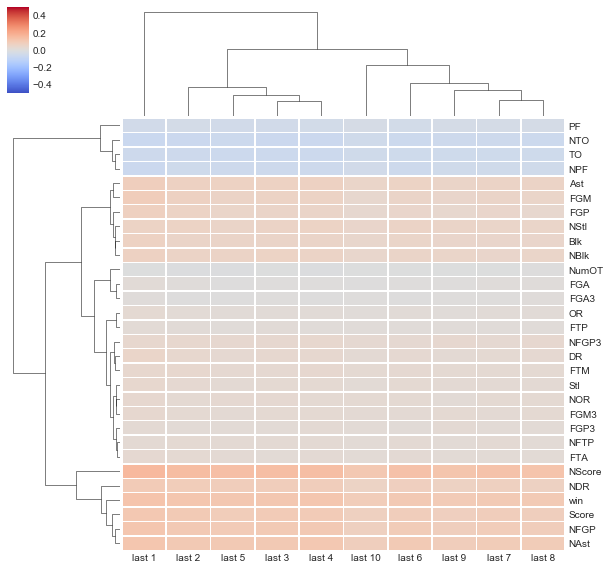

In [156]:
sns.clustermap(last10gameCorrTable,cmap='coolwarm',center = 0,linecolor='w',linewidths = 0.5,vmax = 0.5,
            vmin = -0.5)

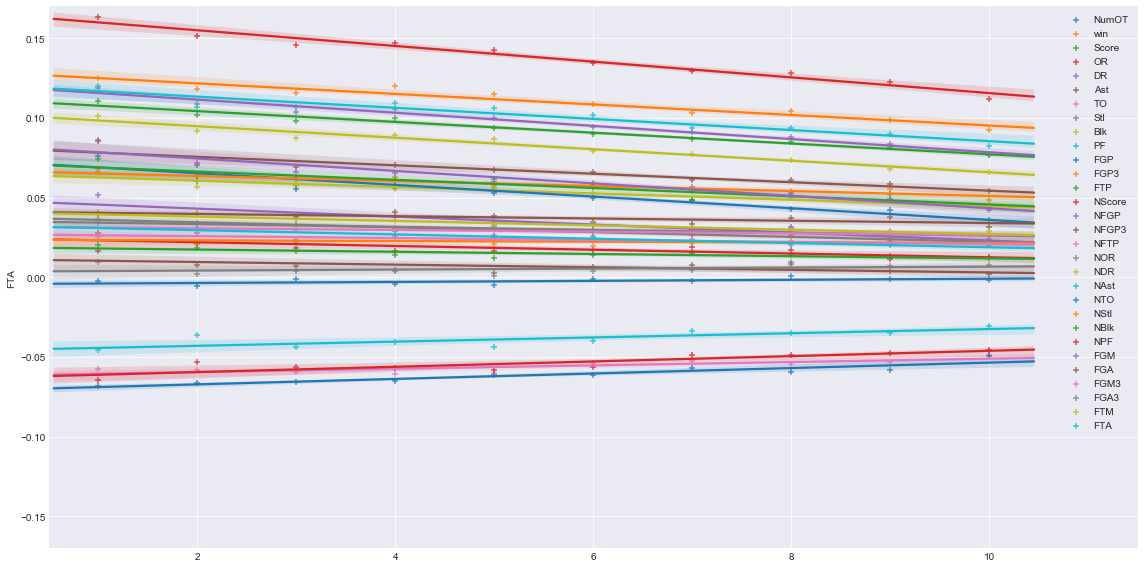

In [154]:
plt.figure(figsize = (16,8))
for i in range(30):
    sns.regplot(x=np.arange(1,11), y=last10gameCorrTable.iloc[i],marker='+',label=label33[i+3])
plt.legend(loc = 1)
plt.tight_layout()
plt.xlim(0.5,11.5)
plt.ylim(-0.17,0.17);

The largest correlation of last 10 games stats to the team winning is **0.16** and is the **net score** of the last game they get. It is not highly correlated but we still can see some interesting pattern. For example, the **net defense rebound** of their last 10 games has higher correlation to the team winning that the **net offense rebound**.

Unsurprisingly, the correlation of 1st last game to the team winning is higher than 10th last game they played.

### Is the team winning correlated to their season's average stats before the game?
        only check the day >= 65, helf regular season

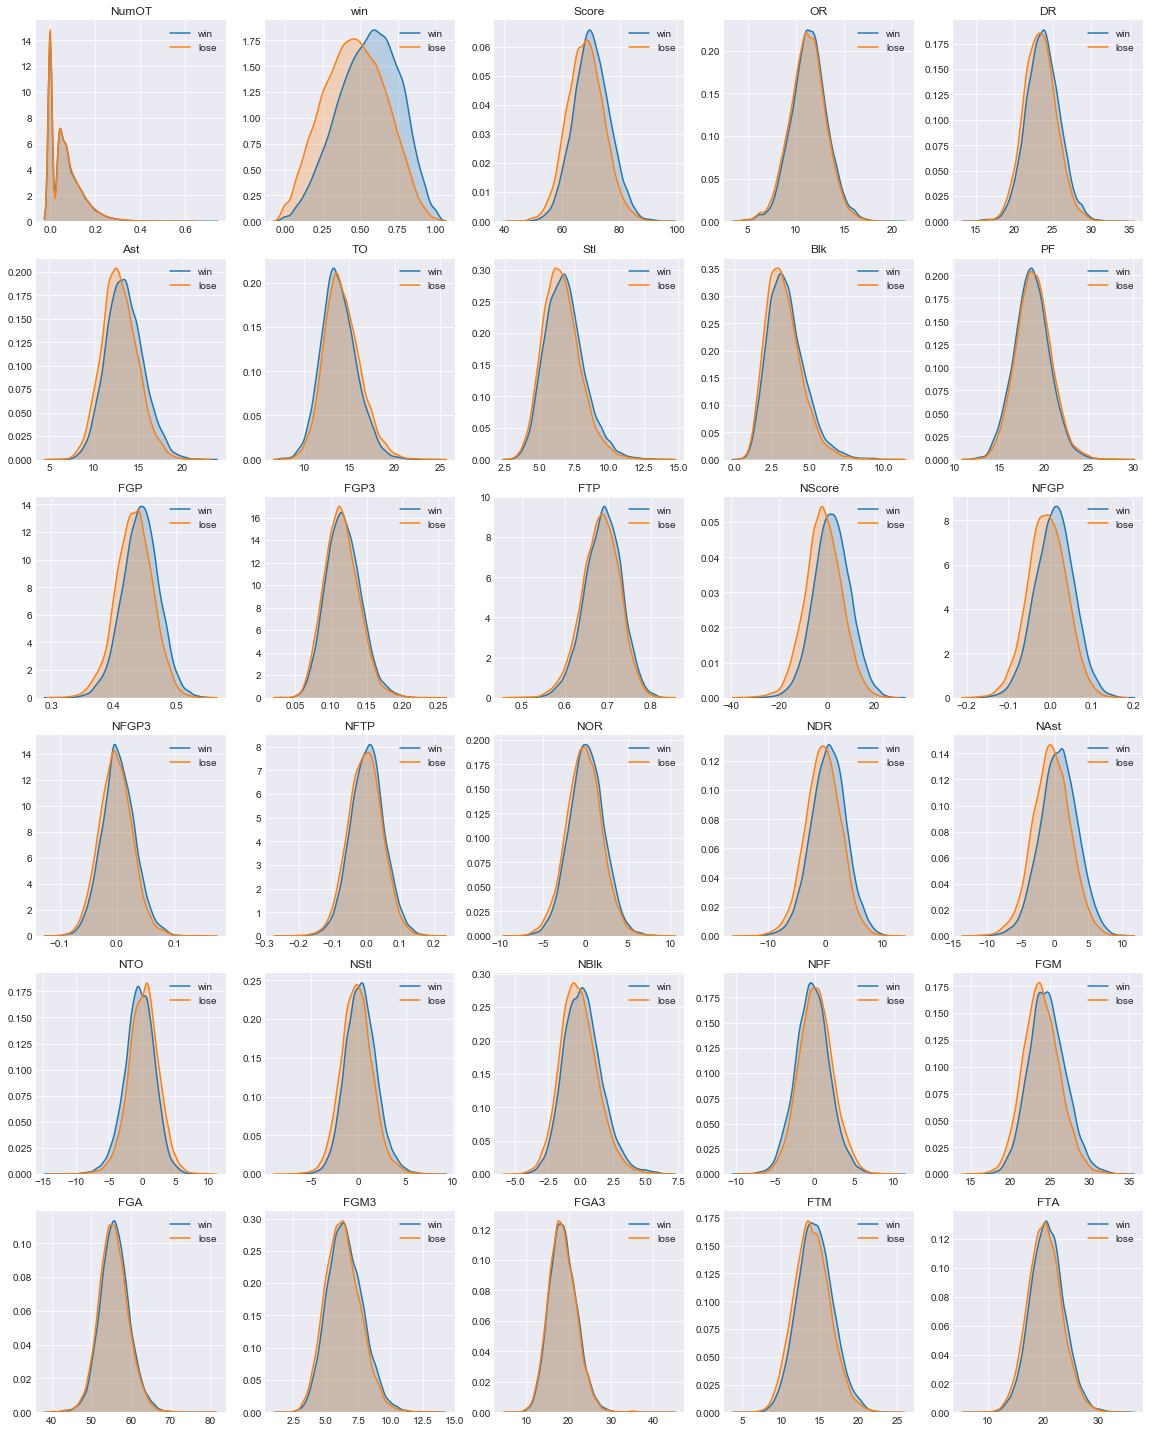

In [162]:
# only show the season after 2003
day = 65
fig, axes = plt.subplots(nrows=6, ncols=5, figsize = (16,20))
for i in xrange(3,len(label33)):
    sns.kdeplot(train[(train["win"] == 1) & (train.Season >= 2003) & (train.DayNum >= day) & (train["3005"] != 0)][str(3000+i)],
                shade = True,label = "win",ax = axes[(i-3)/5][(i-3)%5])
    sns.kdeplot(train[(train["win"] == 0) & (train.Season >= 2003) & (train.DayNum >= day) & (train["3005"] != 0)][str(3000+i)],
                shade=True, label = "lose",ax = axes[(i-3)/5][(i-3)%5])
    axes[(i-3)/5][(i-3)%5].set_title(label33[i])
fig.tight_layout()

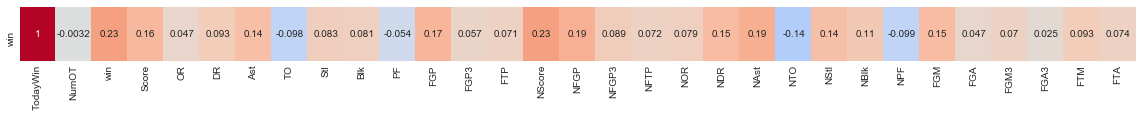

In [189]:
plt.figure(figsize = (20,1))
sns.heatmap(train[(train.Season >= 2003) & (train.DayNum >= day) & (train["3005"] != 0)][
                                                    ["win"]+map(str,range(3003,3033))
                                                    ].corr().iloc[:1],
            xticklabels = ["TodayWin"] + label33[3:],cmap="coolwarm",center = 0,vmax = 0.5,vmin = -0.5,
            cbar = False,annot = True)

### Is the team winning correlated to their last season's average stats?

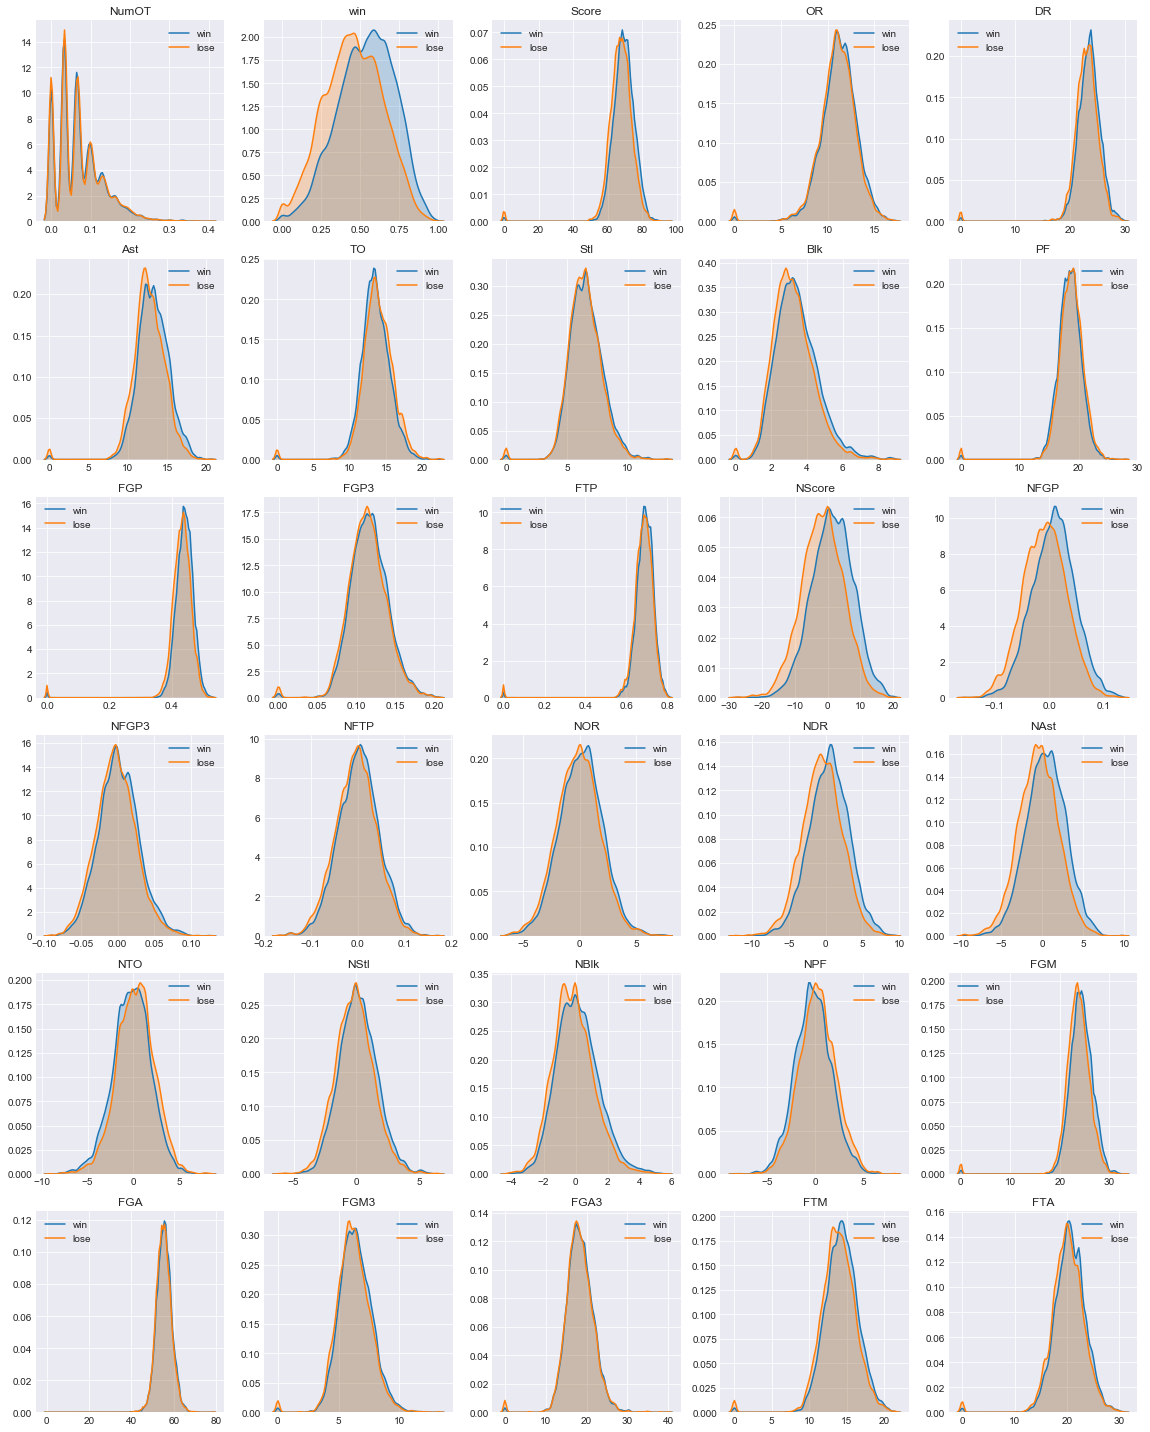

In [190]:
# only show the season after 2004
fig, axes = plt.subplots(nrows=6, ncols=5, figsize = (16,20))
for i in xrange(3,len(label33)):
    sns.kdeplot(train[(train["win"] == 1) & (train.Season >= 2004)  ][str(5000+i)],
                shade = True,label = "win",ax = axes[(i-3)/5][(i-3)%5])
    sns.kdeplot(train[(train["win"] == 0) & (train.Season >= 2004)  ][str(5000+i)],
                shade=True, label = "lose",ax = axes[(i-3)/5][(i-3)%5])
    axes[(i-3)/5][(i-3)%5].set_title(label33[i])
fig.tight_layout()

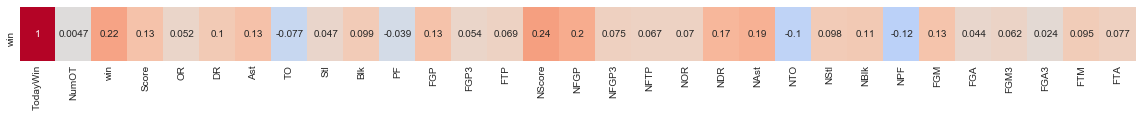

In [191]:
plt.figure(figsize = (20,1))
sns.heatmap(train[(train.Season >= 2004) ][["win"]+map(str,range(5003,5033))].corr().iloc[:1],
            xticklabels = ["TodayWin"] + label33[3:],cmap="coolwarm",center = 0,vmax = 0.5,vmin = -0.5,
            cbar = False,annot = True)

### Tournament win by Seed by Year

In [294]:
seedYearWin = pd.DataFrame(train[(train.tournamy == 1)].groupby(["Season","7000","win"]).count()['aID'])

seedYearWin = seedYearWin.unstack(level=[0,2],fill_value=0)
seedYearWin.index  = range(16,0,-1)
seedYearWin.columns.set_levels( ["l","w"],level = 2,inplace = True)
seedYearWin.columns.set_levels(["Win/Lose count"],level=0,inplace=True)
seedYearWin.sort_index(inplace=True)
seedYearWin.index.names = ["seed"]
seedYearWin

Win/Lose count                                         ...           \
Season           1985     1986     1987     1988     1989     ... 2013       
win                 l   w    l   w    l   w    l   w    l   w ...    l   w   
seed                                                          ...            
1                   4  13    4  13    3  16    4  14    4  11 ...    3  11   
2                   4  11    3  10    4  11    4  10    4  11 ...    4   8   
3                   4   7    4   3    4   4    4   4    3  13 ...    4   8   
4                   4   4    4   5    4   2    4   5    4   6 ...    4  10   
5                   4   5    4   5    4   6    4   6    4   6 ...    4   1   
6                   4   1    4   5    4   9    3  10    4   0 ...    4   4   
7                   4   5    4   6    4   2    4   4    4   3 ...    4   3   
8                   3   7    4   5    4   1    4   3    4   0 ...    4   2   
9                   4   2    4   1    4   3    4   1    4   4 ...    4   5   
10                  4   0    4   1    4   4    4   1    4   1 ...    4   1   
11                  4   5    4   4    4   0    4   2    4   5 ...    5   2   
12                  4   2    4   2    4   2    4   0    4   1 ...    4   4   
13                  4   1    4   0    4   2    4   2    4   1 ...    5   3   
14                  4   0    4   3    4   1    4   1    4   1 ...    4   1   
15                  4   0    4   0    4   0    4   0    4   0 ...    4   2   
16                  4   0    4   0    4   0    4   0    4   0 ...    6   2   

                                            
Season 2014     2015     2016     2017      
win       l   w    l   w    l   w    l   w  
seed                                        
1         4  10    3  16    4  14    3  15  
2         4   9    4   8    3  11    4   7  
3         4   4    4   5    4   5    4   9  
4         4   9    4   7    4   5    4   9  
5         4   1    4   6    4   4    4   3  
6         4   3    4   3    4   3    4   1  
7         3   8    4   7    4   3    4   7  
8         4   7    4   5    4   1    4   4  
9         4   1    4   0    4   3    4   1  
10        4   2    4   1    4   5    4   1  
11        5   6    6   5    6   6    6   7  
12        5   4    4   0    4   2    4   1  
13        4   0    4   0    4   1    4   0  
14        4   1    4   2    4   1    4   0  
15        4   0    4   0    4   1    4   0  
16        6   2    6   2    6   2    6   2  

[16 rows x 66 columns]

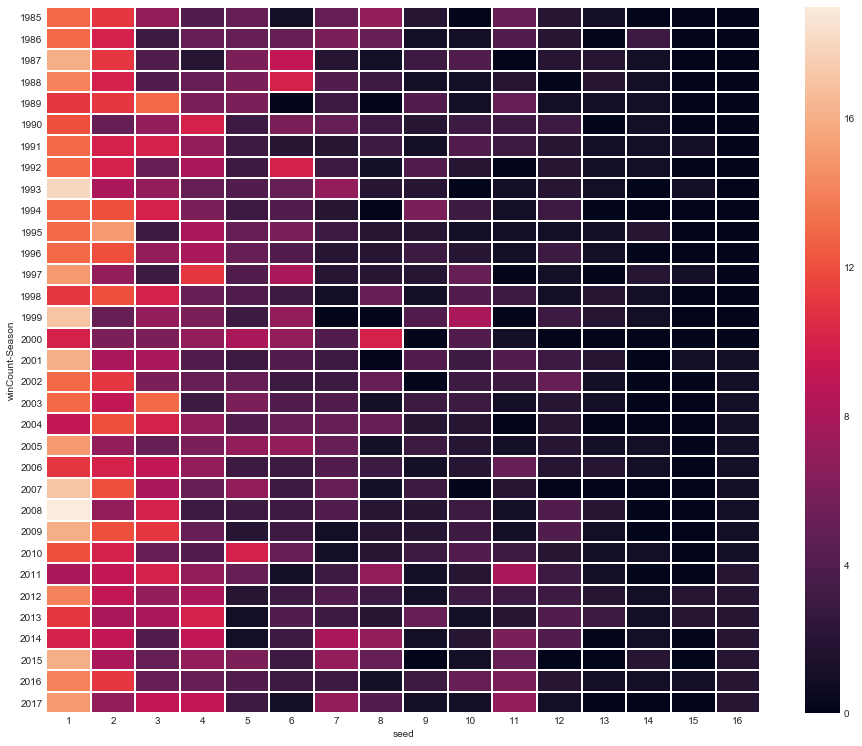

In [338]:
plt.figure(figsize= (16,13))
seedYearWin.columns.set_names(["winCount", u'Season', u'win'],inplace=True)
sns.heatmap(seedYearWin.transpose().xs("w", level="win"),yticklabels=seedYearWin.columns.levels[1],linewidths=1);

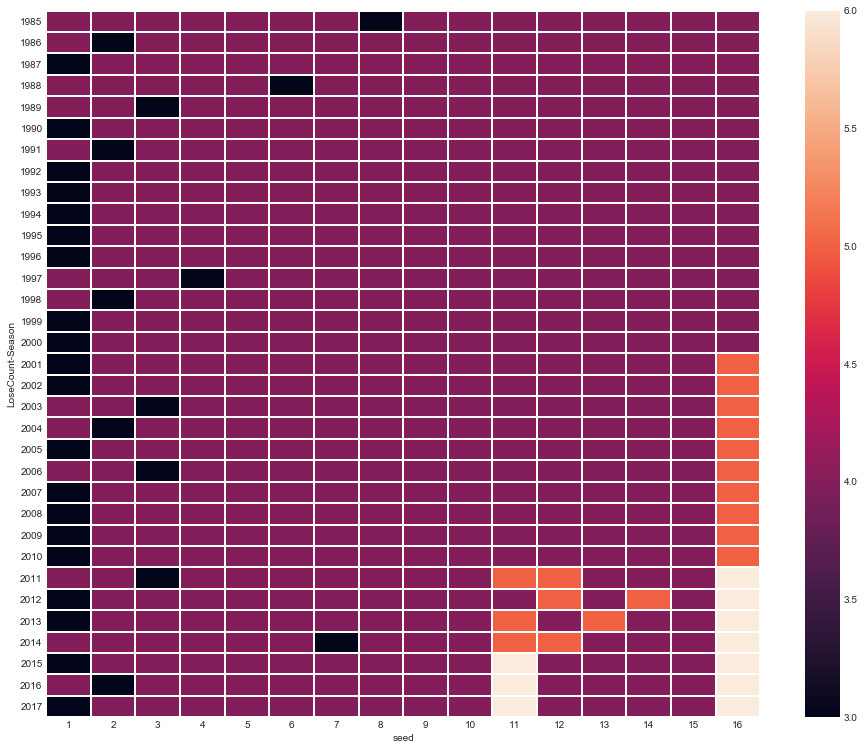

In [337]:
plt.figure(figsize= (16,13))
seedYearWin.columns.set_names(["LoseCount", u'Season', u'win'],inplace=True)
sns.heatmap(seedYearWin.transpose().xs("l", level="win"),yticklabels=seedYearWin.columns.levels[1],linewidths=1);

## Let's combine both teams previous stats together

        TeamAStats - TeamBStats

In [372]:
newtrain = pd.DataFrame(index = range(len(train)))


newtrain[map(str,range(1000,1330))] = train[map(str,range(1000,1330))] - \
                                      np.array(train[map(str,range(2000,2330))])
newtrain["win"] = train.win
newtrain["Season"] = train.Season


last10gameCompressCorrTable = pd.DataFrame(index=label33[3:])
# check the correlation with the last 10 games
i = 0
while i < 10:
    last10gameCompressCorrTable["last " + str(i+1)] = newtrain[(newtrain.Season >= 2003) & 
                                                               ((newtrain[str(1005+i*33)] != 0) |
                                                                (newtrain[str(1006+i*33)] != 0) |
                                                                (newtrain[str(1007+i*33)] != 0))][
                                                    ["win"]+map(str,range(1003+i*33,1033+i*33))
                                                    ].corr().iloc[0,1:].values
    i += 1

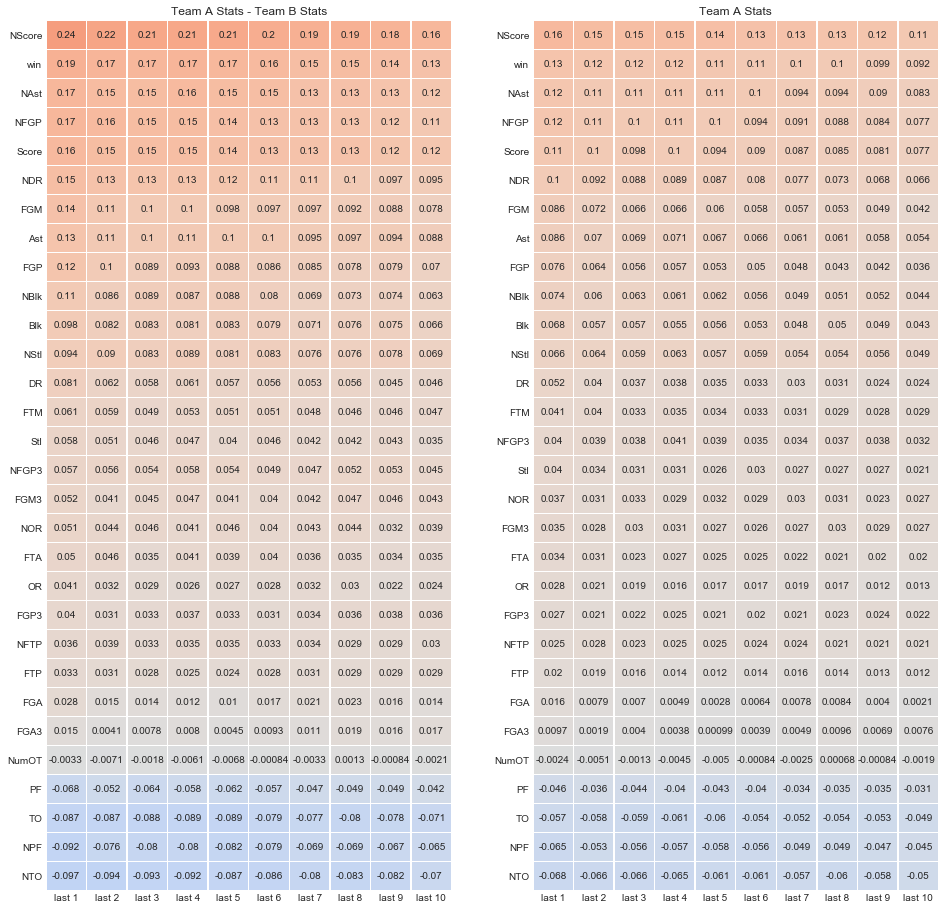

In [371]:
fig,axes = plt.subplots(ncols=2, figsize = (16,16) )
sns.heatmap(last10gameCompressCorrTable.sort_values("last 1",ascending=False),cmap='coolwarm',center = 0,linecolor='w',linewidths = 0.5,vmax = 0.5,
            vmin = -0.5,annot = True,ax = axes[0],cbar = False);
sns.heatmap(last10gameCorrTable.sort_values("last 1",ascending=False),cmap='coolwarm',center = 0,linecolor='w',linewidths = 0.5,vmax = 0.5,
            vmin = -0.5,annot = True,ax = axes[1],cbar = False);
axes[0].title.set_text("Team A Stats - Team B Stats")
axes[1].title.set_text("Team A Stats");

### Seoson's Average

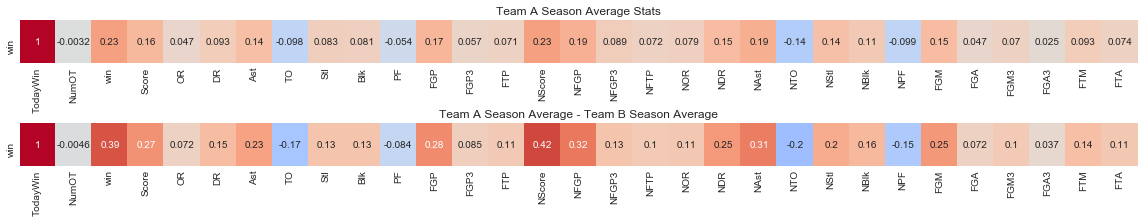

In [381]:
# only show the season after 2003
day = 65
newtrain = train[["win","Season","DayNum"]].copy()
newtrain[map(str,range(3000,3033))] = train[map(str,range(3000,3033))] - \
                                      np.array(train[map(str,range(4000,4033))])
"""
###### distribution plot ########
fig, axes = plt.subplots(nrows=6, ncols=5, figsize = (16,20))
for i in xrange(3,len(label33)):
    sns.kdeplot(newtrain[(newtrain["win"] == 1) & (newtrain.Season >= 2003) & (newtrain.DayNum >= day) & (newtrain["3005"] != 0)][str(3000+i)],
                shade = True,label = "win",ax = axes[(i-3)/5][(i-3)%5])
    sns.kdeplot(newtrain[(newtrain["win"] == 0) & (newtrain.Season >= 2003) & (newtrain.DayNum >= day) & (newtrain["3005"] != 0)][str(3000+i)],
                shade=True, label = "lose",ax = axes[(i-3)/5][(i-3)%5])
    axes[(i-3)/5][(i-3)%5].set_title(label33[i])
fig.tight_layout()
"""
fig,axes = plt.subplots(nrows=2, figsize = (16,3))
sns.heatmap(train[(train.Season >= 2003) & (train.DayNum >= day) & (train["3005"] != 0)][
                                                    ["win"]+map(str,range(3003,3033))
                                                    ].corr().iloc[:1],
            xticklabels = ["TodayWin"] + label33[3:],cmap="coolwarm",center = 0,vmax = 0.5,vmin = -0.5,
            cbar = False,annot = True,ax = axes[0])

sns.heatmap(newtrain[(newtrain.Season >= 2003) & (newtrain.DayNum >= day) & (newtrain["3005"] != 0)][
                                                    ["win"]+map(str,range(3003,3033))
                                                    ].corr().iloc[:1],
            xticklabels = ["TodayWin"] + label33[3:],cmap="coolwarm",center = 0,vmax = 0.5,vmin = -0.5,
            cbar = False,annot = True,ax = axes[1])
fig.tight_layout()
axes[0].title.set_text("Team A Season Average Stats")
axes[1].title.set_text("Team A Season Average - Team B Season Average");

### Last Seoson's Average

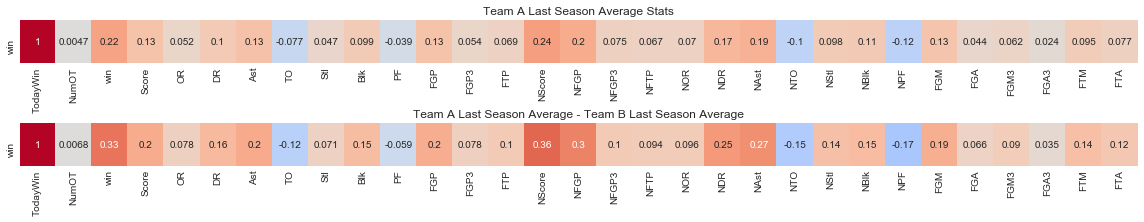

In [385]:
newtrain = train[["win","Season","DayNum"]].copy()
newtrain[map(str,range(5000,5033))] = train[map(str,range(5000,5033))] - \
                                      np.array(train[map(str,range(6000,6033))])

fig,axes = plt.subplots(nrows=2,figsize = (16,3))
sns.heatmap(train[(train.Season >= 2004) ][["win"]+map(str,range(5003,5033))].corr().iloc[:1],
            xticklabels = ["TodayWin"] + label33[3:],cmap="coolwarm",center = 0,vmax = 0.5,vmin = -0.5,
            cbar = False,annot = True,ax = axes[0])

sns.heatmap(newtrain[(newtrain.Season >= 2004) ][["win"]+map(str,range(5003,5033))].corr().iloc[:1],
            xticklabels = ["TodayWin"] + label33[3:],cmap="coolwarm",center = 0,vmax = 0.5,vmin = -0.5,
            cbar = False,annot = True,ax = axes[1])
fig.tight_layout()
axes[0].title.set_text("Team A Last Season Average Stats")
axes[1].title.set_text("Team A Last Season Average - Team B Last Season Average");

# Classification

In [388]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.drop("win",axis = 1), train.win, test_size=0.25, 
                                                    random_state=325)
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=500)
rfc.fit(X_train,y_train)
pred = rfc.predict(X_test)
from sklearn.metrics import confusion_matrix,classification_report
print confusion_matrix(y_test,pred)
print classification_report(y_test,pred)

/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[[28228 10328]
 [10502 28085]]
             precision    recall  f1-score   support

          0       0.73      0.73      0.73     38556
          1       0.73      0.73      0.73     38587

avg / total       0.73      0.73      0.73     77143

